# Classify different data sets

### Basic includes

In [1]:
# Using pandas to load the csv file
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from keras import models 
from keras import layers 
from keras import callbacks
from keras.utils import to_categorical

# reuters and fashin mnist data set from keras
from keras.datasets import reuters
from keras.datasets import fashion_mnist

# needed to preprocess text
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


### Classify the Fashion Mnist

---

(60000, 28, 28)


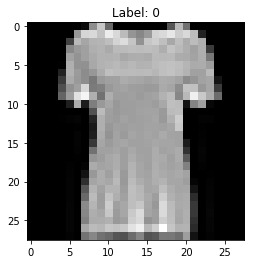

In [5]:
(fashion_train_data, fashion_train_labels), (fashion_test_data, fashion_test_labels) = fashion_mnist.load_data()

print(fashion_train_data.shape)

test_index = 10

plt.title("Label: " + str(fashion_train_labels[test_index]))
plt.imshow(fashion_train_data[test_index], cmap="gray")

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [6]:
fashion_train_data = fashion_train_data.reshape((60000, 28 * 28))
fashion_train_data = fashion_train_data.astype('float32') / 255 

fashion_validation_data = fashion_train_data[:10000]
fashion_train_data = fashion_train_data[10000:]

fashion_train_labels = to_categorical(fashion_train_labels) 

fashion_validation_labels = fashion_train_labels[:10000]
fashion_train_labels = fashion_train_labels[10000:]

fashion_test_data = fashion_test_data.reshape((10000, 28 * 28)) 
fashion_test_data = fashion_test_data.astype('float32') / 255

fashion_test_labels = to_categorical(fashion_test_labels)

#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [14]:
network = models.Sequential()

network.add(layers.Dense(512, activation='relu', input_shape=(784,)))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(10, activation='softmax'))

epochs = 35

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fit_data = network.fit(
    fashion_train_data, 
    fashion_train_labels, 
    batch_size=1000, 
    epochs=epochs, 
    validation_data=(fashion_validation_data, fashion_validation_labels)
)

print("Evaluation: ", network.evaluate(fashion_test_data, fashion_test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 6s 121us/step - loss: 0.7728 - acc: 0.7280 - val_loss: 0.4790 - val_acc: 0.8253
Epoch 2/35
50000/50000 [==============================] - 5s 90us/step - loss: 0.4501 - acc: 0.8398 - val_loss: 0.3954 - val_acc: 0.8583
Epoch 3/35
50000/50000 [==============================] - 5s 90us/step - loss: 0.3931 - acc: 0.8585 - val_loss: 0.3754 - val_acc: 0.8617
Epoch 4/35
50000/50000 [==============================] - 4s 89us/step - loss: 0.3568 - acc: 0.8700 - val_loss: 0.3379 - val_acc: 0.8756
Epoch 5/35
50000/50000 [==============================] - 5s 92us/step - loss: 0.3300 - acc: 0.8809 - val_loss: 0.3414 - val_acc: 0.8762
Epoch 6/35
50000/50000 [==============================] - 5s 97us/step - loss: 0.3103 - acc: 0.8858 - val_loss: 0.3215 - val_acc: 0.8815
Epoch 7/35
50000/50000 [==============================] - 5s 90us/step - loss: 0.2960 - acc: 0.8907 - val_loss: 0.3133 - val_ac

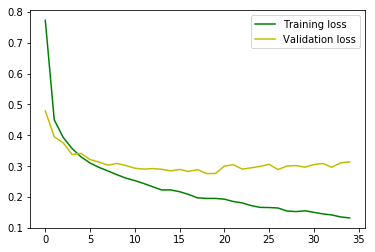

In [25]:
loss = fit_data.history['loss']
acc = fit_data.history['acc']
val_acc = fit_data.history['val_acc']
val_loss = fit_data.history['val_loss']

plt.plot(range(epochs), loss, 'g', label='Training loss')
plt.plot(range(epochs), val_loss, 'y', label='Validation loss')
plt.legend()

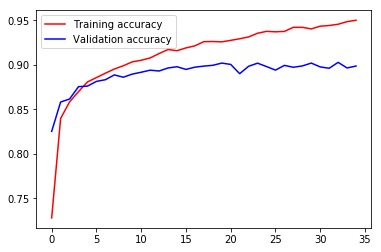

In [26]:
plt.plot(range(epochs), acc, 'r', label='Training accuracy')
plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
plt.legend()

## Classifying newswires

---

Build a network to classify Reuters newswires into 46 different mutually-exclusive topics.

### Load and review the data

In [43]:
(reuters_train_data, reuters_train_labels), (reuters_test_data, reuters_test_labels) = reuters.load_data(num_words=4000)

print(reuters_train_data.shape)
print(reuters_train_labels.shape)
print(reuters_train_data[0])
print(reuters_train_labels[0])

print(set(reuters_train_labels))

(8982,)
(8982,)
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


Load the word index to decode the train data.

In [44]:
word_index = reuters.get_word_index()

reverse_index = dict([(value+3, key) for (key, value) in word_index.items()])

reverse_index[0] = "<PAD>"
reverse_index[1] = "<START>"
reverse_index[2] = "<UNKNOWN>"  # unknown
reverse_index[3] = "<UNUSED>"

decoded_review = ' '.join([reverse_index.get(i,'?') for i in reuters_train_data[0]])

print(decoded_review)

<START> <UNKNOWN> <UNKNOWN> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <UNKNOWN> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [47]:
# Turning the output into vector mode, each of length 5000
tokenizer = Tokenizer(num_words=4000)
train_data_token = tokenizer.sequences_to_matrix(reuters_train_data, mode='binary')
test_data_token = tokenizer.sequences_to_matrix(reuters_test_data, mode='binary')
print(train_data_token.shape)
print(test_data_token.shape)

# One-hot encoding the output
one_hot_train_labels = to_categorical(reuters_train_labels)
one_hot_test_labels = to_categorical(reuters_test_labels)
print(one_hot_train_labels.shape)
print(one_hot_test_labels.shape)

# Creating a validation set with the first 10000 reviews
validation_data = train_data_token[:1000]
validation_labels = one_hot_train_labels[:1000]

# Creating the input set
x_data = train_data_token[1000:]
y_data = one_hot_train_labels[1000:]
print(x_data.shape)
print(y_data.shape)

(8982, 4000)
(2246, 4000)
(8982, 46)
(2246, 46)
(7982, 4000)
(7982, 46)


#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [57]:
network = models.Sequential()

network.add(layers.Dense(512, activation='relu', input_shape=(4000,)))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(46, activation='softmax'))

epochs=35
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8)

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fit_data = network.fit(
    x_data, 
    y_data, 
    batch_size=1000, 
    epochs=epochs,
    callbacks=[early_stop],
    validation_data=(validation_data, validation_labels)
)

print("Evaluation:", network.evaluate(test_data_token, one_hot_test_labels))

Train on 7982 samples, validate on 1000 samples
Epoch 1/35
7982/7982 [==============================] - 4s 511us/step - loss: 3.2652 - acc: 0.3598 - val_loss: 2.2865 - val_acc: 0.5320
Epoch 2/35
7982/7982 [==============================] - 2s 306us/step - loss: 1.9727 - acc: 0.5464 - val_loss: 1.6446 - val_acc: 0.6300
Epoch 3/35
7982/7982 [==============================] - 2s 282us/step - loss: 1.5868 - acc: 0.6495 - val_loss: 1.4084 - val_acc: 0.6890
Epoch 4/35
7982/7982 [==============================] - 2s 260us/step - loss: 1.2964 - acc: 0.7112 - val_loss: 1.2373 - val_acc: 0.7200
Epoch 5/35
7982/7982 [==============================] - 2s 272us/step - loss: 1.0930 - acc: 0.7454 - val_loss: 1.1520 - val_acc: 0.7370
Epoch 6/35
7982/7982 [==============================] - 3s 320us/step - loss: 0.9199 - acc: 0.7796 - val_loss: 1.0872 - val_acc: 0.7530
Epoch 7/35
7982/7982 [==============================] - 3s 321us/step - loss: 0.7622 - acc: 0.8143 - val_loss: 1.0379 - val_acc: 0.7670


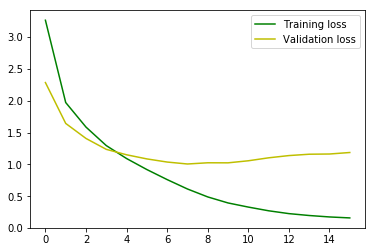

In [58]:
loss = fit_data.history['loss']
acc = fit_data.history['acc']
val_acc = fit_data.history['val_acc']
val_loss = fit_data.history['val_loss']

plt.plot(range(16), loss, 'g', label='Training loss')
plt.plot(range(16), val_loss, 'y', label='Validation loss')
plt.legend()

## Predicting Student Admissions

---

Predict student admissions based on three pieces of data:

- GRE Scores
- GPA Scores
- Class rank

### Load and visualize the data

In [151]:
student_data = pd.read_csv("data/student_data.csv")
print(student_data)

     admit    gre   gpa  rank
0        0  380.0  3.61   3.0
1        1  660.0  3.67   3.0
2        1  800.0  4.00   1.0
3        1  640.0  3.19   4.0
4        0  520.0  2.93   4.0
5        1  760.0  3.00   2.0
6        1  560.0  2.98   1.0
7        0  400.0  3.08   2.0
8        1  540.0  3.39   3.0
9        0  700.0  3.92   2.0
10       0  800.0  4.00   4.0
11       0  440.0  3.22   1.0
12       1  760.0  4.00   1.0
13       0  700.0  3.08   2.0
14       1  700.0  4.00   1.0
15       0  480.0  3.44   3.0
16       0  780.0  3.87   4.0
17       0  360.0  2.56   3.0
18       0  800.0  3.75   2.0
19       1  540.0  3.81   1.0
20       0  500.0  3.17   3.0
21       1  660.0  3.63   2.0
22       0  600.0  2.82   4.0
23       0  680.0  3.19   4.0
24       1  760.0  3.35   2.0
25       1  800.0  3.66   1.0
26       1  620.0  3.61   1.0
27       1  520.0  3.74   4.0
28       1  780.0  3.22   2.0
29       0  520.0  3.29   1.0
..     ...    ...   ...   ...
370      1  540.0  3.77   2.0
371      1

Plot of the GRE and the GPA from the data.

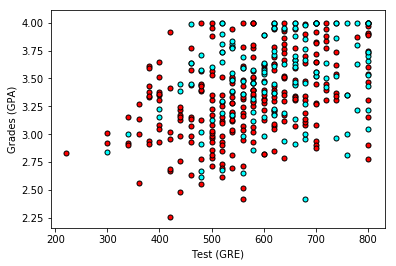

In [152]:
X = np.array(student_data[["gre","gpa"]])
y = np.array(student_data["admit"])
admitted = X[np.argwhere(y==1)]
rejected = X[np.argwhere(y==0)]
plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
plt.xlabel('Test (GRE)')
plt.ylabel('Grades (GPA)')

plt.show()

Plot of the data by class rank.

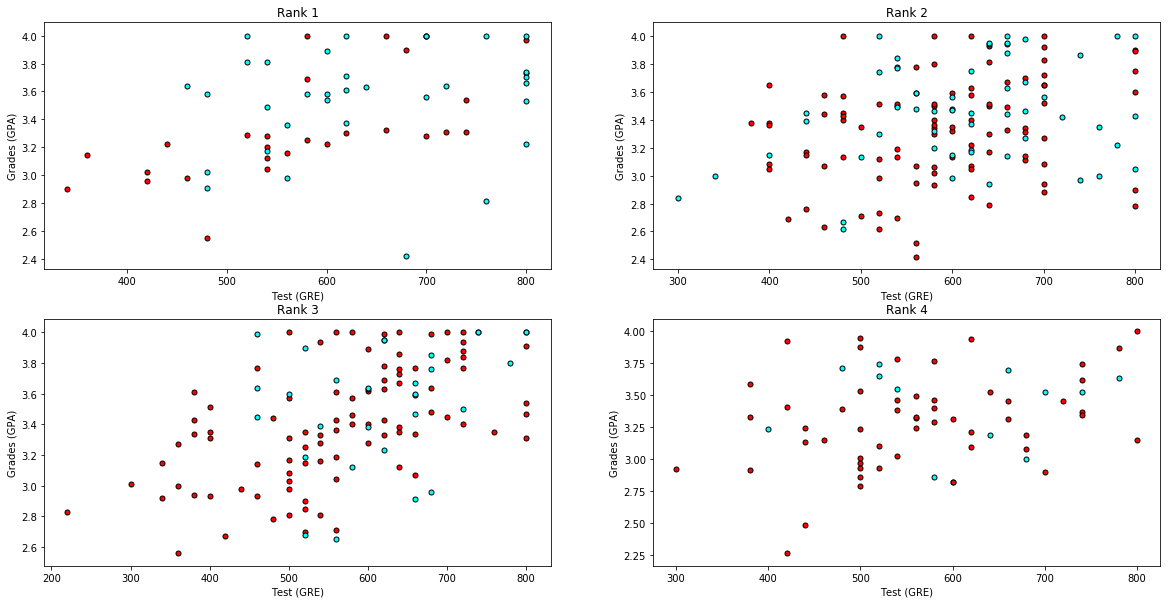

In [153]:
f, plots = plt.subplots(2, 2, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

for idx, plot in enumerate(plots):
    data_rank = student_data[student_data["rank"]==idx+1]
    plot.set_title("Rank " + str(idx+1))
    X = np.array(data_rank[["gre","gpa"]])
    y = np.array(data_rank["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plot.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plot.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plot.set_xlabel('Test (GRE)')
    plot.set_ylabel('Grades (GPA)')   

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [161]:
student_data = np.array(student_data)
student_data = np.array([[0 if np.isnan(el) else el for el in student] for student in student_data])

gre_mean = np.mean(student_data[:,1])
gre_std = np.std(student_data[:,1])
gpa_mean = np.mean(student_data[:,2])
gpa_std = np.std(student_data[:,2])

pp_data = []
pp_labels = []

for (result, gre, gpa, rank) in student_data:
    pp_gre = (gre - gre_mean) / gre_std
    pp_gpa = (gpa - gpa_mean) / gpa_std
    pp_data.append((
        pp_gre,
        pp_gpa,
        1 if rank == 1 else 0,
        1 if rank == 2 else 0,
        1 if rank == 3 else 0,
        1 if rank == 4 else 0
    ))
    pp_labels.append((
        1 if result == 0 else 0,
        1 if result == 1 else 0
    ))
    
pp_data = np.array(pp_data)
pp_labels = np.array(pp_labels)

print(pp_data.shape)
print(pp_labels.shape)

test_data = pp_data[:100]
test_labels = pp_labels[:100]

train_data = pp_data[100:]
train_labels = pp_labels[100:]

(400, 6)
(400, 2)


#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [164]:
network = models.Sequential()

network.add(layers.Dense(128, activation='relu', input_shape=(6,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(2, activation='softmax'))

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)

network.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

fit_data = []

for i in range(4):
    k_val_data = train_data[75 * i : 75 * (i + 1)]
    k_val_labels = train_labels[75 * i : 75 * (i + 1)]
    k_train_data = np.concatenate([train_data[0 : 75 * i], train_data[75 * (i + 1) : 300]])
    k_train_labels = np.concatenate([train_labels[0 : 75 * i], train_labels[75 * (i + 1) : 300]])
    print(k_val_data[0])
    print(k_train_data[0])
    fit_data.append(network.fit(
        k_train_data, 
        k_train_labels, 
        batch_size=225, 
        epochs=1000,
        callbacks=[early_stop], 
        validation_data=(k_val_data, k_val_labels)
    ))

print("Evaluation:", network.evaluate(test_data, test_labels))

[-2.0019012  -0.49957911  0.          0.          1.          0.        ]
[ 0.28505244 -0.00886629  0.          1.          0.          0.        ]
Train on 225 samples, validate on 75 samples
Epoch 1/1000
225/225 [==============================] - 3s 12ms/step - loss: 0.6992 - acc: 0.4178 - val_loss: 0.6921 - val_acc: 0.4267
Epoch 2/1000
225/225 [==============================] - 0s 32us/step - loss: 0.6976 - acc: 0.4356 - val_loss: 0.6897 - val_acc: 0.4533
Epoch 3/1000
225/225 [==============================] - 0s 48us/step - loss: 0.6961 - acc: 0.4444 - val_loss: 0.6874 - val_acc: 0.4800
Epoch 4/1000
225/225 [==============================] - 0s 58us/step - loss: 0.6945 - acc: 0.4578 - val_loss: 0.6852 - val_acc: 0.4933
Epoch 5/1000
225/225 [==============================] - 0s 53us/step - loss: 0.6930 - acc: 0.4844 - val_loss: 0.6830 - val_acc: 0.5200
Epoch 6/1000
225/225 [==============================] - 0s 37us/step - loss: 0.6916 - acc: 0.5067 - val_loss: 0.6808 - val_acc: 0.57

Epoch 60/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6476 - acc: 0.6578 - val_loss: 0.6078 - val_acc: 0.7600
Epoch 61/1000
225/225 [==============================] - 0s 56us/step - loss: 0.6472 - acc: 0.6578 - val_loss: 0.6070 - val_acc: 0.7600
Epoch 62/1000
225/225 [==============================] - 0s 39us/step - loss: 0.6468 - acc: 0.6578 - val_loss: 0.6062 - val_acc: 0.7600
Epoch 63/1000
225/225 [==============================] - 0s 38us/step - loss: 0.6464 - acc: 0.6578 - val_loss: 0.6054 - val_acc: 0.7600
Epoch 64/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6460 - acc: 0.6578 - val_loss: 0.6046 - val_acc: 0.7600
Epoch 65/1000
225/225 [==============================] - 0s 45us/step - loss: 0.6456 - acc: 0.6578 - val_loss: 0.6039 - val_acc: 0.7600
Epoch 66/1000
225/225 [==============================] - 0s 43us/step - loss: 0.6452 - acc: 0.6578 - val_loss: 0.6031 - val_acc: 0.7600
Epoch 67/1000
225/225 [=========================

225/225 [==============================] - 0s 35us/step - loss: 0.6327 - acc: 0.6578 - val_loss: 0.5759 - val_acc: 0.7600
Epoch 121/1000
225/225 [==============================] - 0s 37us/step - loss: 0.6325 - acc: 0.6578 - val_loss: 0.5755 - val_acc: 0.7600
Epoch 122/1000
225/225 [==============================] - 0s 48us/step - loss: 0.6324 - acc: 0.6578 - val_loss: 0.5752 - val_acc: 0.7600
Epoch 123/1000
225/225 [==============================] - 0s 44us/step - loss: 0.6322 - acc: 0.6578 - val_loss: 0.5749 - val_acc: 0.7600
Epoch 124/1000
225/225 [==============================] - 0s 34us/step - loss: 0.6321 - acc: 0.6578 - val_loss: 0.5745 - val_acc: 0.7600
Epoch 125/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6319 - acc: 0.6578 - val_loss: 0.5742 - val_acc: 0.7600
Epoch 126/1000
225/225 [==============================] - 0s 50us/step - loss: 0.6318 - acc: 0.6578 - val_loss: 0.5739 - val_acc: 0.7600
Epoch 127/1000
225/225 [==============================] 

Epoch 180/1000
225/225 [==============================] - 0s 82us/step - loss: 0.6258 - acc: 0.6578 - val_loss: 0.5606 - val_acc: 0.7600
Epoch 181/1000
225/225 [==============================] - 0s 46us/step - loss: 0.6257 - acc: 0.6578 - val_loss: 0.5604 - val_acc: 0.7600
Epoch 182/1000
225/225 [==============================] - 0s 52us/step - loss: 0.6256 - acc: 0.6578 - val_loss: 0.5602 - val_acc: 0.7600
Epoch 183/1000
225/225 [==============================] - 0s 36us/step - loss: 0.6255 - acc: 0.6578 - val_loss: 0.5600 - val_acc: 0.7600
Epoch 184/1000
225/225 [==============================] - 0s 75us/step - loss: 0.6254 - acc: 0.6578 - val_loss: 0.5598 - val_acc: 0.7600
Epoch 185/1000
225/225 [==============================] - 0s 61us/step - loss: 0.6253 - acc: 0.6578 - val_loss: 0.5596 - val_acc: 0.7600
Epoch 186/1000
225/225 [==============================] - 0s 76us/step - loss: 0.6252 - acc: 0.6578 - val_loss: 0.5595 - val_acc: 0.7600
Epoch 187/1000
225/225 [=================

Epoch 240/1000
225/225 [==============================] - 0s 34us/step - loss: 0.6211 - acc: 0.6578 - val_loss: 0.5518 - val_acc: 0.7600
Epoch 241/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6211 - acc: 0.6578 - val_loss: 0.5517 - val_acc: 0.7600
Epoch 242/1000
225/225 [==============================] - 0s 44us/step - loss: 0.6210 - acc: 0.6578 - val_loss: 0.5516 - val_acc: 0.7600
Epoch 243/1000
225/225 [==============================] - 0s 51us/step - loss: 0.6209 - acc: 0.6578 - val_loss: 0.5514 - val_acc: 0.7600
Epoch 244/1000
225/225 [==============================] - 0s 41us/step - loss: 0.6208 - acc: 0.6578 - val_loss: 0.5513 - val_acc: 0.7600
Epoch 245/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6208 - acc: 0.6578 - val_loss: 0.5512 - val_acc: 0.7600
Epoch 246/1000
225/225 [==============================] - 0s 44us/step - loss: 0.6207 - acc: 0.6578 - val_loss: 0.5511 - val_acc: 0.7600
Epoch 247/1000
225/225 [=================

Epoch 300/1000
225/225 [==============================] - 0s 31us/step - loss: 0.6171 - acc: 0.6578 - val_loss: 0.5456 - val_acc: 0.7600
Epoch 301/1000
225/225 [==============================] - 0s 36us/step - loss: 0.6170 - acc: 0.6578 - val_loss: 0.5455 - val_acc: 0.7600
Epoch 302/1000
225/225 [==============================] - 0s 76us/step - loss: 0.6170 - acc: 0.6578 - val_loss: 0.5454 - val_acc: 0.7600
Epoch 303/1000
225/225 [==============================] - 0s 56us/step - loss: 0.6169 - acc: 0.6578 - val_loss: 0.5453 - val_acc: 0.7600
Epoch 304/1000
225/225 [==============================] - 0s 44us/step - loss: 0.6168 - acc: 0.6578 - val_loss: 0.5452 - val_acc: 0.7600
Epoch 305/1000
225/225 [==============================] - 0s 41us/step - loss: 0.6168 - acc: 0.6578 - val_loss: 0.5451 - val_acc: 0.7600
Epoch 306/1000
225/225 [==============================] - 0s 37us/step - loss: 0.6167 - acc: 0.6578 - val_loss: 0.5450 - val_acc: 0.7600
Epoch 307/1000
225/225 [=================

Epoch 360/1000
225/225 [==============================] - 0s 37us/step - loss: 0.6135 - acc: 0.6578 - val_loss: 0.5406 - val_acc: 0.7600
Epoch 361/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6135 - acc: 0.6578 - val_loss: 0.5405 - val_acc: 0.7600
Epoch 362/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6134 - acc: 0.6578 - val_loss: 0.5404 - val_acc: 0.7600
Epoch 363/1000
225/225 [==============================] - 0s 56us/step - loss: 0.6134 - acc: 0.6578 - val_loss: 0.5403 - val_acc: 0.7600
Epoch 364/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6133 - acc: 0.6578 - val_loss: 0.5403 - val_acc: 0.7600
Epoch 365/1000
225/225 [==============================] - 0s 36us/step - loss: 0.6133 - acc: 0.6578 - val_loss: 0.5402 - val_acc: 0.7600
Epoch 366/1000
225/225 [==============================] - 0s 45us/step - loss: 0.6132 - acc: 0.6578 - val_loss: 0.5401 - val_acc: 0.7600
Epoch 367/1000
225/225 [=================

Epoch 420/1000
225/225 [==============================] - 0s 46us/step - loss: 0.6103 - acc: 0.6578 - val_loss: 0.5360 - val_acc: 0.7600
Epoch 421/1000
225/225 [==============================] - 0s 39us/step - loss: 0.6103 - acc: 0.6578 - val_loss: 0.5359 - val_acc: 0.7600
Epoch 422/1000
225/225 [==============================] - 0s 68us/step - loss: 0.6102 - acc: 0.6578 - val_loss: 0.5358 - val_acc: 0.7600
Epoch 423/1000
225/225 [==============================] - 0s 39us/step - loss: 0.6102 - acc: 0.6578 - val_loss: 0.5358 - val_acc: 0.7600
Epoch 424/1000
225/225 [==============================] - 0s 56us/step - loss: 0.6101 - acc: 0.6578 - val_loss: 0.5357 - val_acc: 0.7600
Epoch 425/1000
225/225 [==============================] - 0s 52us/step - loss: 0.6101 - acc: 0.6578 - val_loss: 0.5356 - val_acc: 0.7600
Epoch 426/1000
225/225 [==============================] - 0s 65us/step - loss: 0.6100 - acc: 0.6578 - val_loss: 0.5356 - val_acc: 0.7600
Epoch 427/1000
225/225 [=================

Epoch 480/1000
225/225 [==============================] - 0s 34us/step - loss: 0.6074 - acc: 0.6578 - val_loss: 0.5319 - val_acc: 0.7600
Epoch 481/1000
225/225 [==============================] - 0s 48us/step - loss: 0.6074 - acc: 0.6578 - val_loss: 0.5318 - val_acc: 0.7600
Epoch 482/1000
225/225 [==============================] - 0s 51us/step - loss: 0.6073 - acc: 0.6578 - val_loss: 0.5318 - val_acc: 0.7600
Epoch 483/1000
225/225 [==============================] - 0s 43us/step - loss: 0.6073 - acc: 0.6578 - val_loss: 0.5317 - val_acc: 0.7600
Epoch 484/1000
225/225 [==============================] - 0s 29us/step - loss: 0.6073 - acc: 0.6578 - val_loss: 0.5317 - val_acc: 0.7600
Epoch 485/1000
225/225 [==============================] - 0s 34us/step - loss: 0.6072 - acc: 0.6578 - val_loss: 0.5316 - val_acc: 0.7600
Epoch 486/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6072 - acc: 0.6578 - val_loss: 0.5315 - val_acc: 0.7600
Epoch 487/1000
225/225 [=================

Epoch 540/1000
225/225 [==============================] - 0s 31us/step - loss: 0.6048 - acc: 0.6622 - val_loss: 0.5283 - val_acc: 0.7600
Epoch 541/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6048 - acc: 0.6622 - val_loss: 0.5282 - val_acc: 0.7600
Epoch 542/1000
225/225 [==============================] - 0s 42us/step - loss: 0.6048 - acc: 0.6622 - val_loss: 0.5282 - val_acc: 0.7600
Epoch 543/1000
225/225 [==============================] - 0s 32us/step - loss: 0.6047 - acc: 0.6622 - val_loss: 0.5281 - val_acc: 0.7600
Epoch 544/1000
225/225 [==============================] - 0s 47us/step - loss: 0.6047 - acc: 0.6622 - val_loss: 0.5280 - val_acc: 0.7600
Epoch 545/1000
225/225 [==============================] - 0s 36us/step - loss: 0.6046 - acc: 0.6622 - val_loss: 0.5280 - val_acc: 0.7600
Epoch 546/1000
225/225 [==============================] - 0s 48us/step - loss: 0.6046 - acc: 0.6622 - val_loss: 0.5279 - val_acc: 0.7600
Epoch 547/1000
225/225 [=================

Epoch 600/1000
225/225 [==============================] - 0s 44us/step - loss: 0.6025 - acc: 0.6578 - val_loss: 0.5250 - val_acc: 0.7600
Epoch 601/1000
225/225 [==============================] - 0s 58us/step - loss: 0.6024 - acc: 0.6578 - val_loss: 0.5249 - val_acc: 0.7600
Epoch 602/1000
225/225 [==============================] - 0s 72us/step - loss: 0.6024 - acc: 0.6578 - val_loss: 0.5249 - val_acc: 0.7600
Epoch 603/1000
225/225 [==============================] - 0s 39us/step - loss: 0.6024 - acc: 0.6578 - val_loss: 0.5248 - val_acc: 0.7600
Epoch 604/1000
225/225 [==============================] - 0s 77us/step - loss: 0.6023 - acc: 0.6578 - val_loss: 0.5248 - val_acc: 0.7600
Epoch 605/1000
225/225 [==============================] - 0s 54us/step - loss: 0.6023 - acc: 0.6578 - val_loss: 0.5247 - val_acc: 0.7600
Epoch 606/1000
225/225 [==============================] - 0s 50us/step - loss: 0.6022 - acc: 0.6578 - val_loss: 0.5247 - val_acc: 0.7600
Epoch 607/1000
225/225 [=================

Epoch 660/1000
225/225 [==============================] - 0s 37us/step - loss: 0.6002 - acc: 0.6622 - val_loss: 0.5219 - val_acc: 0.7467
Epoch 661/1000
225/225 [==============================] - 0s 45us/step - loss: 0.6002 - acc: 0.6622 - val_loss: 0.5218 - val_acc: 0.7467
Epoch 662/1000
225/225 [==============================] - 0s 52us/step - loss: 0.6002 - acc: 0.6622 - val_loss: 0.5218 - val_acc: 0.7467
Epoch 663/1000
225/225 [==============================] - 0s 62us/step - loss: 0.6001 - acc: 0.6622 - val_loss: 0.5217 - val_acc: 0.7467
Epoch 664/1000
225/225 [==============================] - 0s 45us/step - loss: 0.6001 - acc: 0.6622 - val_loss: 0.5217 - val_acc: 0.7467
Epoch 665/1000
225/225 [==============================] - 0s 40us/step - loss: 0.6000 - acc: 0.6622 - val_loss: 0.5216 - val_acc: 0.7467
Epoch 666/1000
225/225 [==============================] - 0s 38us/step - loss: 0.6000 - acc: 0.6622 - val_loss: 0.5216 - val_acc: 0.7467
Epoch 667/1000
225/225 [=================

Epoch 720/1000
225/225 [==============================] - 0s 42us/step - loss: 0.5981 - acc: 0.6667 - val_loss: 0.5190 - val_acc: 0.7467
Epoch 721/1000
225/225 [==============================] - 0s 47us/step - loss: 0.5981 - acc: 0.6667 - val_loss: 0.5190 - val_acc: 0.7467
Epoch 722/1000
225/225 [==============================] - 0s 51us/step - loss: 0.5981 - acc: 0.6667 - val_loss: 0.5189 - val_acc: 0.7467
Epoch 723/1000
225/225 [==============================] - 0s 43us/step - loss: 0.5980 - acc: 0.6711 - val_loss: 0.5189 - val_acc: 0.7467
Epoch 724/1000
225/225 [==============================] - 0s 33us/step - loss: 0.5980 - acc: 0.6711 - val_loss: 0.5188 - val_acc: 0.7467
Epoch 725/1000
225/225 [==============================] - 0s 40us/step - loss: 0.5980 - acc: 0.6711 - val_loss: 0.5188 - val_acc: 0.7467
Epoch 726/1000
225/225 [==============================] - 0s 47us/step - loss: 0.5979 - acc: 0.6711 - val_loss: 0.5188 - val_acc: 0.7467
Epoch 727/1000
225/225 [=================

Epoch 780/1000
225/225 [==============================] - 0s 34us/step - loss: 0.5962 - acc: 0.6800 - val_loss: 0.5165 - val_acc: 0.7867
Epoch 781/1000
225/225 [==============================] - 0s 50us/step - loss: 0.5961 - acc: 0.6800 - val_loss: 0.5164 - val_acc: 0.7867
Epoch 782/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5961 - acc: 0.6800 - val_loss: 0.5164 - val_acc: 0.7867
Epoch 783/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5961 - acc: 0.6800 - val_loss: 0.5164 - val_acc: 0.7867
Epoch 784/1000
225/225 [==============================] - 0s 42us/step - loss: 0.5960 - acc: 0.6800 - val_loss: 0.5163 - val_acc: 0.7867
Epoch 785/1000
225/225 [==============================] - 0s 55us/step - loss: 0.5960 - acc: 0.6800 - val_loss: 0.5163 - val_acc: 0.7867
Epoch 786/1000
225/225 [==============================] - 0s 44us/step - loss: 0.5960 - acc: 0.6800 - val_loss: 0.5162 - val_acc: 0.7867
Epoch 787/1000
225/225 [=================

Epoch 840/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5943 - acc: 0.6800 - val_loss: 0.5143 - val_acc: 0.8000
Epoch 841/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5943 - acc: 0.6800 - val_loss: 0.5143 - val_acc: 0.8000
Epoch 842/1000
225/225 [==============================] - 0s 52us/step - loss: 0.5943 - acc: 0.6800 - val_loss: 0.5143 - val_acc: 0.8000
Epoch 843/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5943 - acc: 0.6800 - val_loss: 0.5142 - val_acc: 0.8000
Epoch 844/1000
225/225 [==============================] - 0s 58us/step - loss: 0.5942 - acc: 0.6800 - val_loss: 0.5142 - val_acc: 0.8000
Epoch 845/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5942 - acc: 0.6800 - val_loss: 0.5142 - val_acc: 0.8000
Epoch 846/1000
225/225 [==============================] - 0s 54us/step - loss: 0.5942 - acc: 0.6800 - val_loss: 0.5141 - val_acc: 0.8000
Epoch 847/1000
225/225 [=================

Epoch 900/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5926 - acc: 0.6889 - val_loss: 0.5124 - val_acc: 0.8000
Epoch 901/1000
225/225 [==============================] - 0s 46us/step - loss: 0.5926 - acc: 0.6889 - val_loss: 0.5124 - val_acc: 0.8000
Epoch 902/1000
225/225 [==============================] - 0s 50us/step - loss: 0.5926 - acc: 0.6889 - val_loss: 0.5124 - val_acc: 0.8000
Epoch 903/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5925 - acc: 0.6889 - val_loss: 0.5123 - val_acc: 0.8000
Epoch 904/1000
225/225 [==============================] - 0s 39us/step - loss: 0.5925 - acc: 0.6889 - val_loss: 0.5123 - val_acc: 0.8000
Epoch 905/1000
225/225 [==============================] - 0s 63us/step - loss: 0.5925 - acc: 0.6889 - val_loss: 0.5123 - val_acc: 0.8000
Epoch 906/1000
225/225 [==============================] - 0s 53us/step - loss: 0.5925 - acc: 0.6889 - val_loss: 0.5122 - val_acc: 0.8000
Epoch 907/1000
225/225 [=================

Epoch 960/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5910 - acc: 0.6889 - val_loss: 0.5107 - val_acc: 0.8000
Epoch 961/1000
225/225 [==============================] - 0s 34us/step - loss: 0.5909 - acc: 0.6889 - val_loss: 0.5107 - val_acc: 0.8000
Epoch 962/1000
225/225 [==============================] - 0s 36us/step - loss: 0.5909 - acc: 0.6889 - val_loss: 0.5106 - val_acc: 0.8000
Epoch 963/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5909 - acc: 0.6889 - val_loss: 0.5106 - val_acc: 0.8000
Epoch 964/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5908 - acc: 0.6889 - val_loss: 0.5106 - val_acc: 0.8000
Epoch 965/1000
225/225 [==============================] - 0s 46us/step - loss: 0.5908 - acc: 0.6889 - val_loss: 0.5105 - val_acc: 0.8000
Epoch 966/1000
225/225 [==============================] - 0s 43us/step - loss: 0.5908 - acc: 0.6889 - val_loss: 0.5105 - val_acc: 0.8000
Epoch 967/1000
225/225 [=================

Epoch 19/1000
225/225 [==============================] - 0s 35us/step - loss: 0.5791 - acc: 0.6933 - val_loss: 0.5370 - val_acc: 0.7867
Epoch 20/1000
225/225 [==============================] - 0s 32us/step - loss: 0.5790 - acc: 0.6933 - val_loss: 0.5369 - val_acc: 0.7867
Epoch 21/1000
225/225 [==============================] - 0s 56us/step - loss: 0.5789 - acc: 0.6933 - val_loss: 0.5369 - val_acc: 0.7867
Epoch 22/1000
225/225 [==============================] - 0s 42us/step - loss: 0.5789 - acc: 0.6933 - val_loss: 0.5368 - val_acc: 0.7867
Epoch 23/1000
225/225 [==============================] - 0s 34us/step - loss: 0.5788 - acc: 0.6933 - val_loss: 0.5368 - val_acc: 0.7867
Epoch 24/1000
225/225 [==============================] - 0s 39us/step - loss: 0.5788 - acc: 0.6933 - val_loss: 0.5367 - val_acc: 0.7867
Epoch 25/1000
225/225 [==============================] - 0s 58us/step - loss: 0.5787 - acc: 0.6933 - val_loss: 0.5367 - val_acc: 0.7867
Epoch 26/1000
225/225 [=========================

Epoch 80/1000
225/225 [==============================] - 0s 40us/step - loss: 0.5759 - acc: 0.6978 - val_loss: 0.5346 - val_acc: 0.7867
Epoch 81/1000
225/225 [==============================] - 0s 36us/step - loss: 0.5758 - acc: 0.6978 - val_loss: 0.5346 - val_acc: 0.7867
Epoch 82/1000
225/225 [==============================] - 0s 47us/step - loss: 0.5758 - acc: 0.6978 - val_loss: 0.5346 - val_acc: 0.7867
Epoch 83/1000
225/225 [==============================] - 0s 36us/step - loss: 0.5758 - acc: 0.6978 - val_loss: 0.5346 - val_acc: 0.7867
Epoch 84/1000
225/225 [==============================] - 0s 56us/step - loss: 0.5757 - acc: 0.6978 - val_loss: 0.5345 - val_acc: 0.7867
Epoch 85/1000
225/225 [==============================] - 0s 48us/step - loss: 0.5757 - acc: 0.6978 - val_loss: 0.5345 - val_acc: 0.7867
Epoch 86/1000
225/225 [==============================] - 0s 64us/step - loss: 0.5756 - acc: 0.6978 - val_loss: 0.5345 - val_acc: 0.7867
Epoch 87/1000
225/225 [=========================

Epoch 140/1000
225/225 [==============================] - 0s 52us/step - loss: 0.5733 - acc: 0.7022 - val_loss: 0.5334 - val_acc: 0.7867
Epoch 141/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5732 - acc: 0.7022 - val_loss: 0.5334 - val_acc: 0.7867
Epoch 142/1000
225/225 [==============================] - 0s 44us/step - loss: 0.5732 - acc: 0.7022 - val_loss: 0.5334 - val_acc: 0.7867
Epoch 143/1000
225/225 [==============================] - 0s 48us/step - loss: 0.5732 - acc: 0.7022 - val_loss: 0.5334 - val_acc: 0.7867
Epoch 144/1000
225/225 [==============================] - 0s 59us/step - loss: 0.5731 - acc: 0.7022 - val_loss: 0.5333 - val_acc: 0.7867
Epoch 145/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5731 - acc: 0.7022 - val_loss: 0.5333 - val_acc: 0.7867
Epoch 146/1000
225/225 [==============================] - 0s 47us/step - loss: 0.5730 - acc: 0.7022 - val_loss: 0.5333 - val_acc: 0.7867
Epoch 147/1000
225/225 [=================

Epoch 200/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5710 - acc: 0.7067 - val_loss: 0.5327 - val_acc: 0.8000
Epoch 201/1000
225/225 [==============================] - 0s 33us/step - loss: 0.5710 - acc: 0.7067 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 202/1000
225/225 [==============================] - 0s 43us/step - loss: 0.5709 - acc: 0.7067 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 203/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5709 - acc: 0.7067 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 204/1000
225/225 [==============================] - 0s 39us/step - loss: 0.5708 - acc: 0.7111 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 205/1000
225/225 [==============================] - 0s 30us/step - loss: 0.5708 - acc: 0.7111 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 206/1000
225/225 [==============================] - 0s 34us/step - loss: 0.5708 - acc: 0.7111 - val_loss: 0.5326 - val_acc: 0.8000
Epoch 207/1000
225/225 [=================

Epoch 260/1000
225/225 [==============================] - 0s 51us/step - loss: 0.5689 - acc: 0.7244 - val_loss: 0.5321 - val_acc: 0.7733
Epoch 261/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5689 - acc: 0.7244 - val_loss: 0.5321 - val_acc: 0.7733
Epoch 262/1000
225/225 [==============================] - 0s 45us/step - loss: 0.5689 - acc: 0.7244 - val_loss: 0.5321 - val_acc: 0.7733
Epoch 263/1000
225/225 [==============================] - 0s 45us/step - loss: 0.5688 - acc: 0.7244 - val_loss: 0.5320 - val_acc: 0.7733
Epoch 264/1000
225/225 [==============================] - 0s 51us/step - loss: 0.5688 - acc: 0.7244 - val_loss: 0.5320 - val_acc: 0.7733
Epoch 265/1000
225/225 [==============================] - 0s 57us/step - loss: 0.5688 - acc: 0.7244 - val_loss: 0.5320 - val_acc: 0.7733
Epoch 266/1000
225/225 [==============================] - 0s 48us/step - loss: 0.5687 - acc: 0.7244 - val_loss: 0.5320 - val_acc: 0.7733
Epoch 267/1000
225/225 [=================

Epoch 320/1000
225/225 [==============================] - 0s 77us/step - loss: 0.5671 - acc: 0.7156 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 321/1000
225/225 [==============================] - 0s 36us/step - loss: 0.5670 - acc: 0.7156 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 322/1000
225/225 [==============================] - 0s 46us/step - loss: 0.5670 - acc: 0.7156 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 323/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5670 - acc: 0.7156 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 324/1000
225/225 [==============================] - 0s 40us/step - loss: 0.5670 - acc: 0.7200 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 325/1000
225/225 [==============================] - 0s 44us/step - loss: 0.5669 - acc: 0.7200 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 326/1000
225/225 [==============================] - 0s 42us/step - loss: 0.5669 - acc: 0.7200 - val_loss: 0.5316 - val_acc: 0.7733
Epoch 327/1000
225/225 [=================

Epoch 380/1000
225/225 [==============================] - 0s 46us/step - loss: 0.5654 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 381/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5654 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 382/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5653 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 383/1000
225/225 [==============================] - 0s 45us/step - loss: 0.5653 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 384/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5653 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 385/1000
225/225 [==============================] - 0s 74us/step - loss: 0.5652 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 386/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5652 - acc: 0.7200 - val_loss: 0.5312 - val_acc: 0.7733
Epoch 387/1000
225/225 [=================

Epoch 440/1000
225/225 [==============================] - 0s 49us/step - loss: 0.5638 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 441/1000
225/225 [==============================] - 0s 44us/step - loss: 0.5638 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 442/1000
225/225 [==============================] - 0s 40us/step - loss: 0.5638 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 443/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5637 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 444/1000
225/225 [==============================] - 0s 52us/step - loss: 0.5637 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 445/1000
225/225 [==============================] - 0s 53us/step - loss: 0.5637 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 446/1000
225/225 [==============================] - 0s 38us/step - loss: 0.5637 - acc: 0.7200 - val_loss: 0.5311 - val_acc: 0.7733
Epoch 447/1000
225/225 [=================

Epoch 500/1000
225/225 [==============================] - 0s 60us/step - loss: 0.5623 - acc: 0.7244 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 501/1000
225/225 [==============================] - 0s 37us/step - loss: 0.5623 - acc: 0.7244 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 502/1000
225/225 [==============================] - 0s 93us/step - loss: 0.5623 - acc: 0.7244 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 503/1000
225/225 [==============================] - 0s 47us/step - loss: 0.5623 - acc: 0.7244 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 504/1000
225/225 [==============================] - 0s 36us/step - loss: 0.5622 - acc: 0.7244 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 505/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5622 - acc: 0.7289 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 506/1000
225/225 [==============================] - 0s 41us/step - loss: 0.5622 - acc: 0.7289 - val_loss: 0.5310 - val_acc: 0.7733
Epoch 507/1000
225/225 [=================

Epoch 9/1000
225/225 [==============================] - 0s 40us/step - loss: 0.5400 - acc: 0.7467 - val_loss: 0.5917 - val_acc: 0.7067
Epoch 10/1000
225/225 [==============================] - 0s 45us/step - loss: 0.5399 - acc: 0.7467 - val_loss: 0.5918 - val_acc: 0.7067
Epoch 11/1000
100/100 [==============================] - 0s 354us/step
Evaluation: [0.5888395178318023, 0.73]


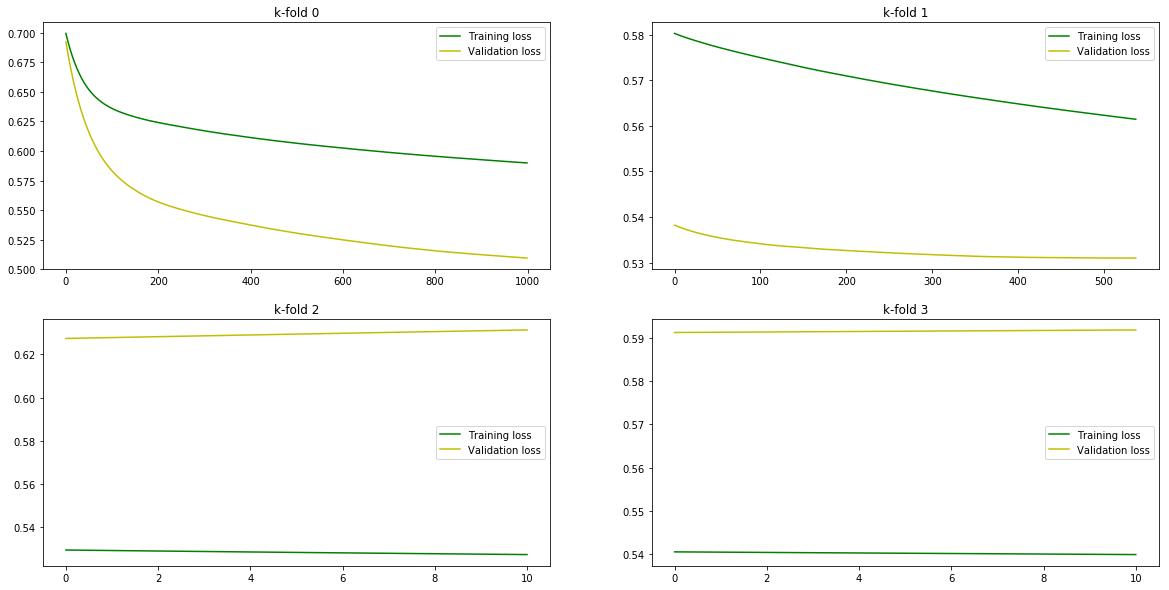

In [171]:
f, plots = plt.subplots(2, 2, figsize=(20, 10))

for (i, (k_fit_data, plot)) in enumerate(zip(fit_data, [plot for sublist in plots for plot in sublist])):
    loss = k_fit_data.history['loss']
    val_loss = k_fit_data.history['val_loss']
    
    plot.plot(range(len(loss)), loss, 'g', label='Training loss')
    plot.plot(range(len(val_loss)), val_loss, 'y', label='Validation loss')
    plot.set_title('k-fold ' + str(i))
    plot.legend()

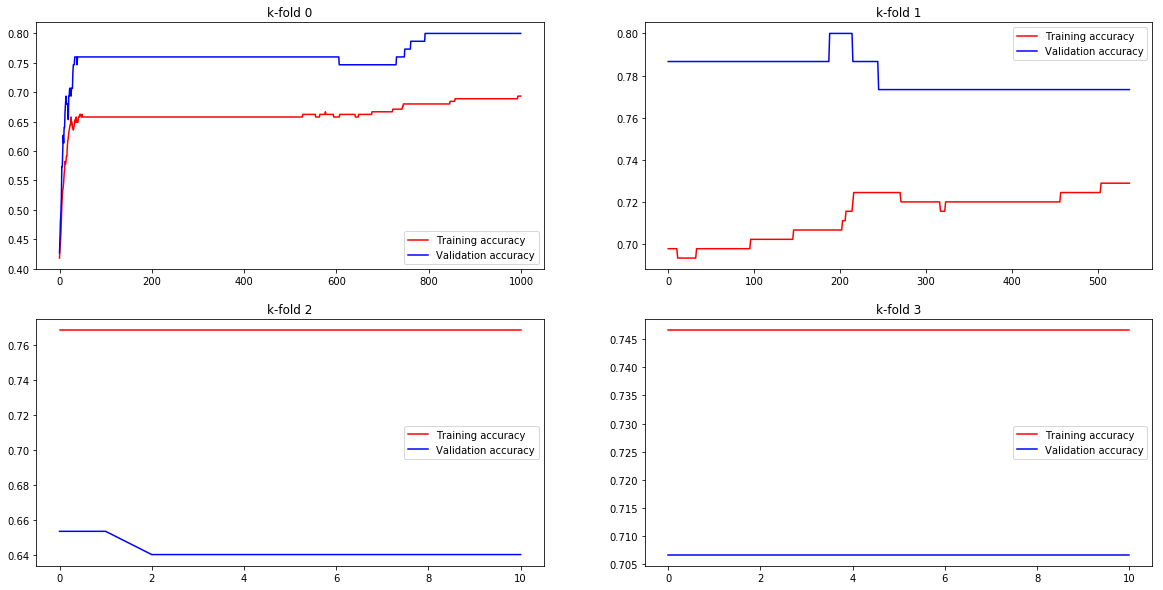

In [172]:
f, plots = plt.subplots(2, 2, figsize=(20, 10))

for (i, (k_fit_data, plot)) in enumerate(zip(fit_data, [plot for sublist in plots for plot in sublist])):
    acc = k_fit_data.history['acc']
    val_acc = k_fit_data.history['val_acc']
    
    plot.plot(range(len(acc)), acc, 'r', label='Training accuracy')
    plot.plot(range(len(val_acc)), val_acc, 'b', label='Validation accuracy')
    plot.set_title('k-fold ' + str(i))
    plot.legend()